# Bibliotecas

In [1]:
from obterDados import obterSimboloPosicao, obterSimboloData
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

# Obtendo dados

In [2]:
rawDataM5 = obterSimboloPosicao('WDO$N')
rawDataM5

,open,high,low,close,tick_volume,real_volume
time,,,,,,
2020-01-21 12:00:00,4204.0,4205.0,4202.5,4204.0,1938,8761
2020-01-21 12:05:00,4204.0,4206.0,4203.5,4204.5,2064,8493
2020-01-21 12:10:00,4204.5,4205.0,4200.5,4200.5,3023,11783
2020-01-21 12:15:00,4200.5,4203.5,4199.5,4202.5,3415,12904
2020-01-21 12:20:00,4202.5,4205.5,4202.5,4205.0,2098,7592
...,...,...,...,...,...,...
2023-09-19 17:35:00,4878.0,4879.0,4877.5,4878.0,612,10182
2023-09-19 17:40:00,4878.0,4878.5,4877.5,4878.0,495,5478
2023-09-19 17:45:00,4878.0,4878.5,4875.0,4875.5,1309,14140


In [3]:
rawDataM5[:-252*108]

,open,high,low,close,tick_volume,real_volume
time,,,,,,
2020-01-21 12:00:00,4204.0,4205.0,4202.5,4204.0,1938,8761
2020-01-21 12:05:00,4204.0,4206.0,4203.5,4204.5,2064,8493
2020-01-21 12:10:00,4204.5,4205.0,4200.5,4200.5,3023,11783
2020-01-21 12:15:00,4200.5,4203.5,4199.5,4202.5,3415,12904
2020-01-21 12:20:00,4202.5,4205.5,4202.5,4205.0,2098,7592
...,...,...,...,...,...,...
2022-09-22 11:25:00,5182.0,5186.0,5178.0,5182.0,16432,74328
2022-09-22 11:30:00,5182.0,5187.0,5178.0,5185.5,15844,56609
2022-09-22 11:35:00,5185.5,5191.5,5183.0,5189.5,15123,53868


In [4]:
rawDataM5['minute'] = rawDataM5.index.minute
rawDataM5['hour'] = rawDataM5.index.hour
rawDataM5['day_of_week'] = rawDataM5.index.day_of_week
rawDataM5['day'] = rawDataM5.index.day
rawDataM5NP = rawDataM5.to_numpy()
# rawNP = rawDataM5[:-252*108].to_numpy()
rawDataM5NP

array([[4.2040e+03, 4.2050e+03, 4.2025e+03, ..., 1.2000e+01, 1.0000e+00,
        2.1000e+01],
       [4.2040e+03, 4.2060e+03, 4.2035e+03, ..., 1.2000e+01, 1.0000e+00,
        2.1000e+01],
       [4.2045e+03, 4.2050e+03, 4.2005e+03, ..., 1.2000e+01, 1.0000e+00,
        2.1000e+01],
       ...,
       [4.8780e+03, 4.8785e+03, 4.8750e+03, ..., 1.7000e+01, 1.0000e+00,
        1.9000e+01],
       [4.8760e+03, 4.8770e+03, 4.8745e+03, ..., 1.7000e+01, 1.0000e+00,
        1.9000e+01],
       [4.8750e+03, 4.8765e+03, 4.8740e+03, ..., 1.7000e+01, 1.0000e+00,
        1.9000e+01]])

In [5]:
# np.save(open('data/raw/rawDataM5.npy', 'wb'), rawNP)

# Tratamento de Dados

### Gerando colunas com preços passados

In [7]:
nPassado = 300
nFuturo = 24
histM5NP = np.zeros((len(rawDataM5NP)-(nPassado+nFuturo), nPassado+1, 6))
for i in tqdm(range(len(histM5NP))):
    histM5NP[i, 0, -4:] = rawDataM5NP[i:i+nPassado][-1][-4:]
    histM5NP[i, 1:] = rawDataM5NP[i:i+nPassado, :6]

100%|██████████| 99675/99675 [00:00<00:00, 111823.02it/s]


### Achar quando comprar, vender ou fazer nada

In [8]:
pontos = 30
y = np.zeros((len(histM5NP)))
for i in tqdm(range(len(y))):
    ultimoPreco = histM5NP[i, -1, 3]
    for j in range(nFuturo):
        # nao fazer nada se for mais de 14hs
        # if rawNP[nPassado+i+j, -3] > 14:
        #     break
        # comprar
        if rawDataM5NP[nPassado+i+j, 1] >= ultimoPreco + pontos:
            y[i] = 1
            break
        # vender
        if rawDataM5NP[nPassado+i+j, 2] <= ultimoPreco - pontos:
            y[i] = 2
            break

100%|██████████| 99675/99675 [00:01<00:00, 56496.63it/s]


# Obtendo histórico D1

In [10]:
histNP = np.zeros((histM5NP.shape[0], histM5NP.shape[1] + 200, histM5NP.shape[2]))

for i in tqdm(range(len(histNP))):
    rawDataD1 = obterSimboloData(rawDataM5.index[i+nFuturo])
    rawDataD1NP = rawDataD1.to_numpy()
    histNP[i, :histM5NP.shape[1]] = histM5NP[i]
    histNP[i, histM5NP.shape[1]:] = rawDataD1NP
    

100%|██████████| 99675/99675 [16:17<00:00, 101.93it/s]


### Normalização

In [11]:
histNPNorm = np.zeros(histNP.shape, dtype=np.float64)
for i in tqdm(range(len(histNPNorm))):
    # preços
    vmax = histNP[i, 1:, :4].max()
    vmin = histNP[i, 1:, :4].min()
    histNPNorm[i, 1:, :4] = (histNP[i, 1:, :4] - vmin) / (vmax - vmin)
    # tick volume
    vmax = histNP[i, 1:, 4].max()
    vmin = histNP[i, 1:, 4].min()
    histNPNorm[i, 1:, 4] = (histNP[i, 1:, 4] - vmin) / (vmax - vmin)
    # real volume
    vmax = histNP[i, 1:, 5].max()
    vmin = histNP[i, 1:, 5].min()
    histNPNorm[i, 1:, 5] = (histNP[i, 1:, 5] - vmin) / (vmax - vmin)
# minuto
histNPNorm[:, 0, 2] = histNP[:, 0, 2] / 60
# hora
histNPNorm[:, 0, 3] = histNP[:, 0, 3] / 24
# dia da semana
histNPNorm[:, 0, 4] = histNP[:, 0, 4] / 4
# dia
histNPNorm[:, 0, 5] = histNP[:, 0, 5] / 31


100%|██████████| 99675/99675 [00:14<00:00, 6935.57it/s]


### Sem Reshape para 2d no caso para CNNs

In [12]:
x = histNPNorm

### Balanceamento de Classes

[57481 20673 21521]


([<matplotlib.patches.Wedge at 0x2b6a404da80>,
 [Text(-0.26244576737134995, 1.0682332232190044, '0.0'),
  Text(-0.46594023596609985, -0.996443523993134, '1.0'),
  Text(0.8565000637785553, -0.6902228920771398, '2.0')])

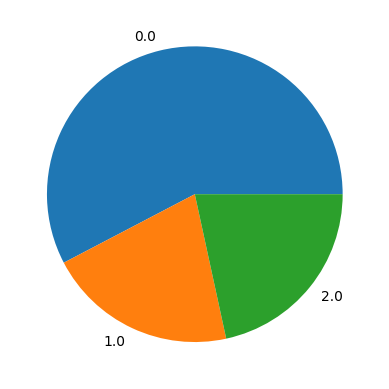

In [13]:
unicos, contagem = np.unique(y, return_counts=True)
print(contagem)
plt.pie(contagem, labels=unicos)

In [14]:
amostra = contagem.min()
Amostragem = np.zeros((amostra * 3, x.shape[1], x.shape[2] + 1), dtype=np.float64)

for i in range(3):
    xClasse_i = x[y == i]
    xAmostra = xClasse_i[np.random.choice(xClasse_i.shape[0], size=amostra, replace=False)]
    Amostragem[i*amostra:(i+1)*amostra, :, :-1] = xAmostra
    Amostragem[i*amostra:(i+1)*amostra, :, -1] = i

Amostragem.shape

(62019, 501, 7)

In [15]:
np.random.shuffle(Amostragem)
x = Amostragem[:, :, :-1]
y = Amostragem[:, :, -1][:, 0]
y

array([1., 2., 2., ..., 2., 2., 0.])

[20673 20673 20673]


([<matplotlib.patches.Wedge at 0x2b6a40b9cc0>,
 [Text(0.5499999702695115, 0.9526279613277875, '0.0'),
  Text(-1.0999999999999954, -1.0298943258065002e-07, '1.0'),
  Text(0.5500001486524352, -0.9526278583383436, '2.0')])

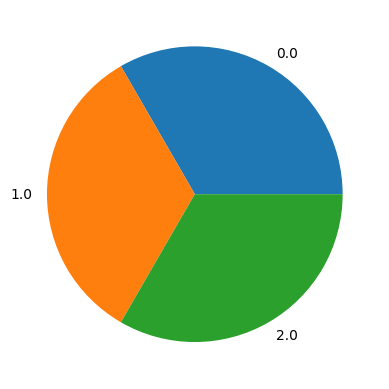

In [16]:
unicos, contagem = np.unique(y, return_counts=True)
print(contagem)
plt.pie(contagem, labels=unicos)

### Separar dados de treino e teste

In [17]:
np.save(open('data/cnn/x.npy', 'wb'), x)
np.save(open('data/cnn/y.npy', 'wb'), y)

In [18]:
x = np.float64(np.load(open('data/cnn/x.npy', 'rb')))
y = np.int8(np.load(open('data/cnn/y.npy', 'rb')))

In [19]:
from keras.utils import to_categorical

y_one_hot = to_categorical(y, 3)
y_one_hot

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [20]:
# from sklearn.model_selection import train_test_split

# x_train, x_test, y_train, y_test = train_test_split(x, y_one_hot, test_size=0.2)

# Criar Modelo

In [29]:
modelo = Sequential()

modelo.add(Conv2D(128, (15, 3), activation='relu', input_shape=(501, 6, 1)))
modelo.add(MaxPooling2D((2, 2)))

modelo.add(Flatten())
modelo.add(Dense(128, activation='relu'))
modelo.add(Dense(128, activation='relu'))
modelo.add(Dense(3, activation='softmax'))

modelo.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

modelo.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 487, 4, 128)       5888      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 243, 2, 128)       0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 62208)             0         
                                                                 
 dense_15 (Dense)            (None, 256)               15925504  
                                                                 
 dense_16 (Dense)            (None, 256)               65792     
                                                                 
 dense_17 (Dense)            (None, 3)                 771       
                                                      

# Treinar Modelo

In [30]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
# checkpoint_filepath = '/tmp/checkpoint'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True
# )
parada_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=15, restore_best_weights=True
)
modelo.fit(
    x,
    y_one_hot,
    shuffle=True, 
    epochs=200,
    batch_size=64,
    validation_split=0.2,
    callbacks=[tensorboard_callback, parada_callback]
)

Epoch 1/100
776/776 [==============================] - 339s 435ms/step - loss: 1.0509 - accuracy: 0.4339 - val_loss: 1.0102 - val_accuracy: 0.4749
Epoch 2/100
776/776 [==============================] - 447s 576ms/step - loss: 0.9534 - accuracy: 0.5200 - val_loss: 0.9146 - val_accuracy: 0.5487
Epoch 3/100
776/776 [==============================] - 482s 621ms/step - loss: 0.8797 - accuracy: 0.5778 - val_loss: 0.8398 - val_accuracy: 0.6098
Epoch 4/100
776/776 [==============================] - 494s 637ms/step - loss: 0.7883 - accuracy: 0.6393 - val_loss: 0.7521 - val_accuracy: 0.6617
Epoch 5/100
776/776 [==============================] - 504s 650ms/step - loss: 0.6826 - accuracy: 0.6988 - val_loss: 0.6618 - val_accuracy: 0.7165
Epoch 6/100
776/776 [==============================] - 522s 673ms/step - loss: 0.5957 - accuracy: 0.7491 - val_loss: 0.5838 - val_accuracy: 0.7609
Epoch 7/100
776/776 [==============================] - 524s 675ms/step - loss: 0.5277 - accuracy: 0.7815 - val_loss: 0

In [31]:
modelo.save('models/tf-cnn-model')

INFO:tensorflow:Assets written to: models/tf-cnn-model\assets


INFO:tensorflow:Assets written to: models/tf-cnn-model\assets


# Pontuação de treino e teste

In [32]:
from keras.models import load_model

modelo = load_model('models/tf-cnn-model')
modelo.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 487, 4, 128)       5888      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 243, 2, 128)       0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 62208)             0         
                                                                 
 dense_15 (Dense)            (None, 256)               15925504  
                                                                 
 dense_16 (Dense)            (None, 256)               65792     
                                                                 
 dense_17 (Dense)            (None, 3)                 771       
                                                      

In [33]:
# modelo.evaluate(x_test, y_test)

# Teste Finaceiro

In [38]:
from json import dumps

target = 30
stop = 10
timeLimit = 24
total = 0
long = False
short = False
position = 0
candle = -1
operacoes = {
    'longSuccess' : [0, 0],
    'longFail' : [0, 0],
    'longEndSuccess' : [0, 0],
    'longEndFail' : [0, 0],
    'shortSuccess' : [0, 0],
    'shortFail' : [0, 0],
    'shortEndSuccess' : [0, 0],
    'shortEndFail' : [0, 0],
}
for i in tqdm(range(252*108, -1, -1)):
    histM5 = obterSimboloPosicao('WDO$N', n=300, delayCandles=i)
    histM5['minute'] = histM5.index.minute
    histM5['hour'] = histM5.index.hour
    histM5['day_of_week'] = histM5.index.day_of_week
    histM5['day'] = histM5.index.day
    histM5NP = histM5.to_numpy()
    hist = np.zeros((501, 6))
    hist[0, -4:] = histM5NP[-1][-4:]
    hist[1:301] = histM5NP[:, :6]
    histD1 = obterSimboloData(histM5.index[-1])
    histD1NP = rawDataD1.to_numpy()
    hist[301:] = histD1NP
    vmax = hist[1:, :4].max()
    vmin = hist[1:, :4].min()
    hist[1:, :4] = (hist[1:, :4] - vmin) / (vmax - vmin)
    vmax = hist[1:, 4].max()
    vmin = hist[1:, 4].min()
    hist[1:, 4] = (hist[1:, 4] - vmin) / (vmax - vmin)
    vmax = hist[1:, 5].max()
    vmin = hist[1:, 5].min()
    hist[1:, 5] = (hist[1:, 5] - vmin) / (vmax - vmin)
    hist[0, 2] /= 60
    hist[0, 3] /= 24
    hist[0, 4] /= 4
    hist[0, 5] /= 31
    priceNow = histM5['close'].iloc[-1]
    if long:
        if priceNow >= position + target:
            total += priceNow - position
            long = False
            operacoes['longSuccess'][0] += 1
            operacoes['longSuccess'][1] += priceNow - position
        if priceNow <= position - stop:
            total += priceNow - position
            long = False
            operacoes['longFail'][0] += 1
            operacoes['longFail'][1] += priceNow - position
        if i >= candle + timeLimit:
            total += priceNow - position
            long = False
            if priceNow - position > 0:
                operacoes['longEndSuccess'][0] += 1
                operacoes['longEndSuccess'][1] += priceNow - position
            else:
                operacoes['longEndFail'][0] += 1
                operacoes['longEndFail'][1] += priceNow - position
        continue
    if short:
        if priceNow <= position - target:
            total += position - priceNow
            short = False
            operacoes['shortSuccess'][0] += 1
            operacoes['shortSuccess'][1] += position - priceNow
        if priceNow >= position + stop:
            total += position - priceNow
            short = False
            operacoes['shortFail'][0] += 1
            operacoes['shortFail'][1] += position - priceNow
        if i >= candle + timeLimit:
            total += position - priceNow
            short = False
            if position - priceNow > 0:
                operacoes['shortEndSuccess'][0] += 1
                operacoes['shortEndSuccess'][1] += position - priceNow
            else:
                operacoes['shortEndFail'][0] += 1
                operacoes['shortEndFail'][1] += position - priceNow
        continue

    previsao = np.argmax(modelo.predict(np.array([hist]), verbose=0)[0])
    if previsao == 1:
        long = True
        position = priceNow
        candle = i
    if previsao == 2:
        short = True
        position = priceNow
        candle = i

print('Total:', total)
print('Operações: ', dumps(operacoes, indent=4))

  0%|          | 0/27217 [00:00<?, ?it/s]

  0%|          | 0/27217 [00:00<?, ?it/s]


IndexError: index 27240 is out of bounds for axis 0 with size 300